### Expectation-Maximization (EM) algorithm using MAP estimation 

Example notebook using the EM algorithm with MAP estimation to perform parameter recovery for a simple Rescorla-Wagner reinforcement learning model (i.e., simulations, model fitting)

In [17]:
%load_ext autoreload
%autoreload 2

In [37]:
import numpy as np
from pyem.core.em import EMfit, _calc_group_gaussian
from pyem.models.rw import rw_simulate, rw_fit
from pyem.api import EMModel
from pyem.utils import plotting

In [2]:
# simulate like before
nsubjects, nblocks, ntrials = 150, 6, 24
params = np.column_stack([np.random.randn(nsubjects), np.random.randn(nsubjects)])
sim = rw_simulate(params, nblocks=nblocks, ntrials=ntrials)
all_data = [[c, r] for c, r in zip(sim['choices'], sim['rewards'])]

In [ ]:
out = EMfit(
    all_data, rw_fit, ['beta','lr'],
    mstep_maxit=100, njobs=-1, optim_method='BFGS', max_restarts=2
)

5746.8207 (000), 0.0775 (001), 0.0167 (002), 0.0047 (003), 0.0015 (004), 0.0006 (005), 

In [9]:
m, inv_h, posterior, NPL, NLPrior, NLL, convergence = out.values()

In [24]:
def _calc_group_gaussian(m: np.ndarray, inv_h: np.ndarray, covmat: bool = False) -> tuple[np.ndarray,np.ndarray,int]:
    # m: (nparams, nsubjects), inv_h: (nparams,nparams,nsubjects)
    nsub = m.shape[1]
    npar = m.shape[0]
    mu = np.mean(m, axis=1)
    sigma = np.zeros(npar)
    for s in range(nsub):
        sigma += m[:, s]**2 + np.diag(inv_h[:, :, s])
    sigma = sigma / nsub - mu**2
    flag = 1
    if np.min(sigma) < 0:
        flag = 0

    if not covmat:
        return mu, sigma, flag
    else:
        covmat = np.zeros((npar, npar))
        for isub in range(nsub):
            covmat += np.outer(m[:, isub], m[:, isub]) - np.outer(m[:, isub], mu) - np.outer(mu, m[:, isub]) + np.outer(mu, mu) + inv_h[:, :, isub]
        covmat /= nsub

        if np.linalg.det(covmat) <= 0:
            print('Negative/zero determinant - prior covariance not updated')

        return mu, sigma, flag, covmat

In [31]:
## Now store all relevant outputs in modfit_dict and save
modfit_dict = {}
modfit_dict['norm_params'] = m.T.copy()
modfit_dict['est_params'] = m.T.copy()
modfit_dict['param_names'] = ['beta','lr']
modfit_dict['inverse_hess'] = inv_h
modfit_dict['gauss.mu'] = posterior['mu']
modfit_dict['gauss.sigma'] = posterior['sigma']
modfit_dict['NPL'] = NPL  # note: this is the negative joint posterior likelihood
modfit_dict['NLPrior'] = NLPrior
modfit_dict['NLL'] = NPL - NLPrior

# get covariance matrix
_, _, _, covmat_out = _calc_group_gaussian(m,inv_h,True) 
modfit_dict['gauss.cov'] = covmat_out
try:
    modfit_dict['gauss.corr'] = np.corrcoef(covmat_out)
except:
    print('covariance mat not square, symmetric, or positive semi-definite')
    modfit_dict['gauss.corr'] = np.eye(len(param_names))

# Calculate integrated BIC
# modfit_dict['BICint'] = calc_BICint(all_data, param_names, posterior['mu'], posterior['sigma'], rw_models.fit, nll_output='CHOICE_NLL')

# from mfit_optimize_hierarchical.m from Sam Gershman
# Also reference Daw 2009 (Equation 17) for Laplace approximation
# Laplace_approx, lme, goodHessian = calc_LME(inv_h, NPL)
# modfit_dict['Laplace_approx'] = Laplace_approx
# modfit_dict['lme'] = lme
# modfit_dict['goodHessian'] = goodHessian

# Get subject specific fits
modfit_dict['choices']     = np.empty((nsubjects, nblocks, ntrials,), dtype='object')
modfit_dict['rewards']     = np.zeros((nsubjects, nblocks, ntrials,))
modfit_dict['EV']          = np.zeros((nsubjects, nblocks, ntrials+1, 2))
modfit_dict['CH_PROB']     = np.zeros((nsubjects, nblocks, ntrials,   2))
modfit_dict['CHOICES_A']   = np.zeros((nsubjects, nblocks, ntrials,))
modfit_dict['PE']          = np.zeros((nsubjects, nblocks, ntrials,))
modfit_dict['CHOICE_NLL']       = np.zeros((nsubjects,))

for subj_idx in range(nsubjects):

    # get info for current subject
    choices = sim['choices'][subj_idx,:,:]
    rewards = sim['rewards'][subj_idx,:,:]
    subj_fit = rw_fit(m[:,subj_idx], choices, rewards, prior=None, output='all')

    # store model fits
    modfit_dict['est_params'][subj_idx,:] = subj_fit['params']
    modfit_dict['choices'][subj_idx,:,:] = subj_fit['choices']
    modfit_dict['rewards'][subj_idx,:,:] = subj_fit['rewards']
    modfit_dict['EV'][subj_idx,:,:,:] = subj_fit['EV']
    modfit_dict['CHOICE_NLL'][subj_idx] = subj_fit['CHOICE_NLL']


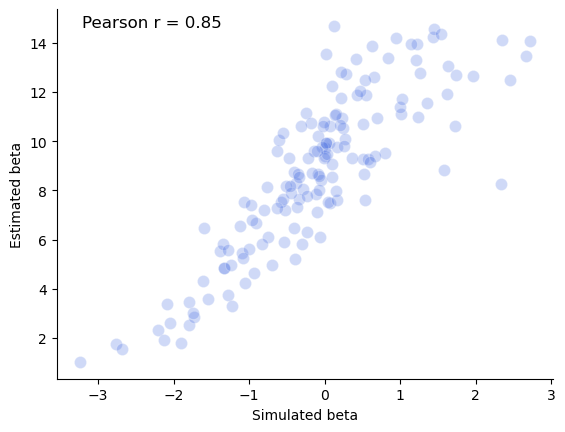

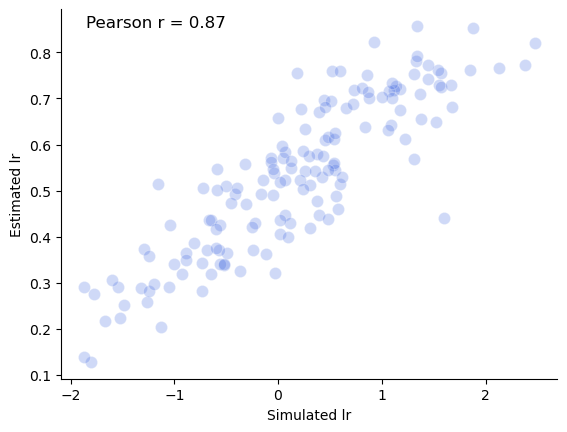

In [38]:
# show parameter recovery
for param_idx, param_label in enumerate(['beta','lr']):
    simulated_param = sim['params'][:,param_idx]
    fitted_params = modfit_dict['est_params'][:,param_idx]
    plotting.plot_scatter(simulated_param, f'Simulated {param_label}', 
                 fitted_params, f'Estimated {param_label}')

In [ ]:
model = EMModel(all_data=all_data, fit_func=rw_fit, param_names=['beta','lr'])
res = model.fit(mstep_maxit=100, njobs=-1, optim_method='BFGS', max_restarts=2)

In [39]:
print(res.convergence, res.posterior_mu, res.posterior_sigma)

True [-0.32267819  0.1395459 ] [0.73900846 0.70945474]


In [ ]:
# two fits to compare (example)
m1 = EMModel(all_data=all_data, fit_func=rw_fit, param_names=["beta","lr"])
m2 = EMModel(all_data=all_data, fit_func=rw_fit, param_names=["beta","lr"])
r1 = m1.fit(mstep_maxit=50, verbose=0)
r2 = m2.fit(mstep_maxit=50, verbose=0)

In [44]:
from pyem.core.compare import compare_models

rows = compare_models(
    [("RW-1", r1.__dict__, all_data, rw_fit),
     ("RW-2", r2.__dict__, all_data, rw_fit)],
    bicint_kwargs={"nsamples": 2000, "func_output": "all", "nll_key": "CHOICE_NLL"},
    r2_kwargs={"ntrials": 6*24, "nopts": 2}
)

In [45]:
rows

[ComparisonRow(name='RW-2', LME=-5211.389799343635, BICint=None, R2=np.float64(0.6771913041387696)),
 ComparisonRow(name='RW-1', LME=-5211.389834606692, BICint=None, R2=np.float64(0.677191296563143))]

In [46]:
from pyem.core.posterior import posterior_predictive_check

def stat_fn(all_data):  # e.g., mean reward
    import numpy as np
    return float(np.mean([r for _, r in all_data]))

def assemble(sim):
    return [[c, r] for c, r in zip(sim["choices"], sim["rewards"])]

ppc = posterior_predictive_check(
    simulate_func=rw_simulate,
    fit_result=r1.__dict__,
    all_data=all_data,
    stat_fn=stat_fn,
    n_sims=200,
    assemble_data=assemble
)
print(ppc.p_value)


0.4626865671641791


In [47]:
shared = np.array([True, False])  # beta = shared (fixed effect), lr random effect
res = m1.fit(mstep_maxit=50, verbose=0, shared_mask=shared)
assert (res.m[0, :] == res.m[0, 0]).all()  # all subjects share beta


AssertionError: 